#**Imports**

In [1]:
!pip install pyLDAvis
!pip install nltk

     |████████████████████████████████| 1.6MB 5.1MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=5e03559009e9b99f480c2945b622154761b48bad0bdaf2298d045c91b822453d
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [2]:
#Import libraries
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 1000)

from IPython.display import display, HTML
display(HTML(data="""
<style>
   div#notebook-container    { width: 95%; }
   div#menubar-container     { width: 95%; }
   div#maintoolbar-container { width: 99%; }
</style>
"""))

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
import os
PATH = os.getcwd()
DATADIR = PATH + '/drive/My Drive/Short.csv'

In [5]:
#Read data
raw_data = pd.read_csv(DATADIR)
raw_data.shape

(18425, 4)

In [6]:
raw_data.head()

Index   Source              Text  Length
0      1  Susanli         Plandemic       9
1      2    Coaid         ÒBreaking      10
2      3  Susanli       Alcohol ban      11
3      4    Coaid      ÒCoronavirus      13
4      5  Susanli  Coronavirus & 5G      16

#**Preprocessing**

In [7]:
# NLTK Stop words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['com', 'response', 'request'])

# Convert to list
data = raw_data.Text.values.tolist()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
#print(trigram_mod[bigram_mod[data_words[3]]])

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(data_lemmatized[:1])

In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
#print(corpus[:1])

In [13]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:5]]

[[], [('obreaking', 1)], [], [], []]

In [14]:
len(corpus)

18425

#**Compute coherence scores for N topics**

In [15]:
%%time
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10 µs


In [16]:
%%time
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=20, step=1)

CPU times: user 18min 28s, sys: 4.8 s, total: 18min 33s
Wall time: 18min 35s


In [17]:
import seaborn as sns
plt.style.use("seaborn")

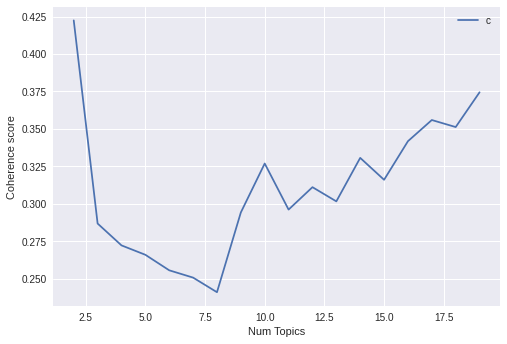

In [23]:
## Plot the coherence scores for different N topics
### Select optimum N

# Show graph
limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [20]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4224
Num Topics = 3  has Coherence Value of 0.2869
Num Topics = 4  has Coherence Value of 0.2723
Num Topics = 5  has Coherence Value of 0.266
Num Topics = 6  has Coherence Value of 0.2557
Num Topics = 7  has Coherence Value of 0.2508
Num Topics = 8  has Coherence Value of 0.241
Num Topics = 9  has Coherence Value of 0.2943
Num Topics = 10  has Coherence Value of 0.3269
Num Topics = 11  has Coherence Value of 0.2962
Num Topics = 12  has Coherence Value of 0.3111
Num Topics = 13  has Coherence Value of 0.3017
Num Topics = 14  has Coherence Value of 0.3307
Num Topics = 15  has Coherence Value of 0.3161
Num Topics = 16  has Coherence Value of 0.3418
Num Topics = 17  has Coherence Value of 0.356
Num Topics = 18  has Coherence Value of 0.3513
Num Topics = 19  has Coherence Value of 0.3745


#**Model Selection**

In [26]:
max_index = max(enumerate(coherence_values),key=lambda x: x[1])[0]

# Select the model and print the topics
#optimal_model = model_list[max_index]
optimal_model = model_list[17]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=30))


[(0,
  '0.140*"say" + 0.102*"make" + 0.035*"man" + 0.028*"create" + 0.024*"week" + '
  '0.022*"live" + 0.019*"life" + 0.019*"profit" + 0.018*"lose" + '
  '0.017*"evidence" + 0.017*"company" + 0.016*"push" + 0.015*"fear" + '
  '0.014*"effective" + 0.013*"law" + 0.012*"instal" + 0.012*"other" + '
  '0.011*"school" + 0.010*"service" + 0.010*"connect" + 0.010*"move" + '
  '0.008*"friend" + 0.007*"arrest" + 0.007*"finance" + 0.007*"target" + '
  '0.007*"s" + 0.006*"apparently" + 0.006*"collapse" + 0.006*"front" + '
  '0.006*"weaken"'),
 (1,
  '0.067*"country" + 0.046*"share" + 0.038*"child" + 0.035*"send" + '
  '0.027*"scientist" + 0.024*"multiple" + 0.023*"allow" + 0.021*"change" + '
  '0.020*"american" + 0.017*"false" + 0.017*"mind" + 0.016*"important" + '
  '0.014*"situation" + 0.014*"hard" + 0.014*"can" + 0.013*"small" + '
  '0.013*"discuss" + 0.013*"sick" + 0.012*"safety" + 0.012*"prison" + '
  '0.012*"falsely" + 0.011*"vote" + 0.009*"several" + 0.009*"version" + '
  '0.008*"expect" + 

#**Dominant Topic in each post and Topic Weight**

In [27]:
%%time
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)


CPU times: user 1min 34s, sys: 974 ms, total: 1min 35s
Wall time: 1min 35s


In [28]:
#most representative sentence for each topic
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib                                           Keywords                 Text
0            0             8.0              0.0972  co, story, back, source, see, think, tell, goo...            Plandemic
1            1             8.0              0.0964  co, story, back, source, see, think, tell, goo...            ÒBreaking
2            2             8.0              0.0972  co, story, back, source, see, think, tell, goo...          Alcohol ban
3            3             8.0              0.0972  co, story, back, source, see, think, tell, goo...         ÒCoronavirus
4            4             8.0              0.0972  co, story, back, source, see, think, tell, goo...     Coronavirus & 5G
5            5             8.0              0.0972  co, story, back, source, see, think, tell, goo...    THE GATES OF HELL
6            6             8.0              0.0939  co, story, back, source, see, think, tell, goo...    ÒPutin has stated
7            7             8.0              0.0972  co, story, back, source, see, think, tell, goo...    ÒCoronavirus hoax
8            8             8.0              0.0972  co, story, back, source, see, think, tell, goo...   Covid 19 bioweapon
9            9             8.0              0.0972  co, story, back, source, see, think, tell, goo...  UPDATES Wuhan Virus

In [29]:
df_dominant_topic.to_csv('topics.csv')

In [30]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet

Topic_Num  Topic_Perc_Contrib                                                                                             Keywords                                                                                  Representative Text
0         0.0              0.3000                                     say, make, man, create, week, live, life, profit, lose, evidence  @Europarl_EN @guardian @CommonsEFRA @RSPCA_Frontline @World_Wildlife @christian_aid @ECIReform @...
1         1.0              0.2168                     country, share, child, send, scientist, multiple, allow, change, american, false  RT @Sultanknish: Heroic 'Whistleblowing' Scientist Touted by the Media Was Busted for Revenge Po...
2         2.0              0.2706                              vaccine, fact, help, cure, way, military, available, early, drug, force  Drinking hot water with lemons will cure or prevent COVID-19; drinking hot water with lemons and...
3         3.0              0.2264                                 covid, also, take, get, include, symptom, great, place, crisis, talk  ÒWeÕve got to give the American public a rough estimate of how long we think this is going to ta...
4         4.0              0.2123                                 virus, death, many, corona, home, tower, human, order, today, number                                            “People defying stay-at-home order fill Arizona beaches.”
5         5.0              0.2403                                            https, post, want, find, try, fake, let, late, base, must  Were Ventilators Found ‘Stashed’ in a Warehouse in New York?\nSocial media posts painted a misle...
6         6.0              0.2545                                    know, use, time, twitter, cause, need, give, control, start, high  When even tough New Yorkers become petrified pandemic-shamers, it’s time to confront our over-an...
7         7.0              0.2419                        video, show, may, pandemic, test, patient, radiation, bad, global, population  2019 coronavirus can live for Òup to 3 hours in the air, up to 4 hours on copper, up to 24 hours...
8         8.0              0.2597                                   co, story, back, source, see, think, tell, good, factly, treatment  How genius can be derailed by an over-active ego - long read, but reminds us that we should stil...
9         9.0              0.2028                             go, government, lockdown, body, put, image, contain, affect, power, face  Photos of a Chinese man eating “human baby soup” that circulated on social networking platforms....
10       10.0              0.2689  claim, new, factly, facebook, novel, stop, viral, collated_gathered, either_available, factual_e...  #BorderInvasion #BuildTheWall #NoAmnesty #DeportIllegals #22MillionIllegals #NewAmericans  While...
11       11.0              0.2161                                comment, trump, die, due, group, public, issue, jump, regard, similar  RT @MorganFeldman7: “Fauci earned a medical degree in 1966, but w/o advanced degrees in molecula...
12       12.0              0.2646                                  right, amp, state, could, look, news, really, vitamin, protect, flu  Right before corona virus came.CEO of disney stepped down. CEO of Tinder, Hinge, OKcupid, Match ...
13       13.0              0.1945                                    world, come, work, article, happen, end, ask, question, plan, big  Scientists at the university caution that their results are continually evolving and inexact– an...
14       14.0              0.2468                          watch, health, year, read, day, disease, thing, realdonaldtrump, next, ever  'Prizing a superficially-diverse student body over a competent one ends up disadvantaging everyo...
15       15.0              0.2514                             kill, research, well, science, lead, update, last, lot, different, water  RT @thelisagraves: Rosa Parks showed genuine courage in risking her life to pursue equal jus

In [31]:
sent_topics_sorteddf_mallet.to_csv('keywords.csv')

#**Word clouds for top words in each topic**

IndexError: ignored

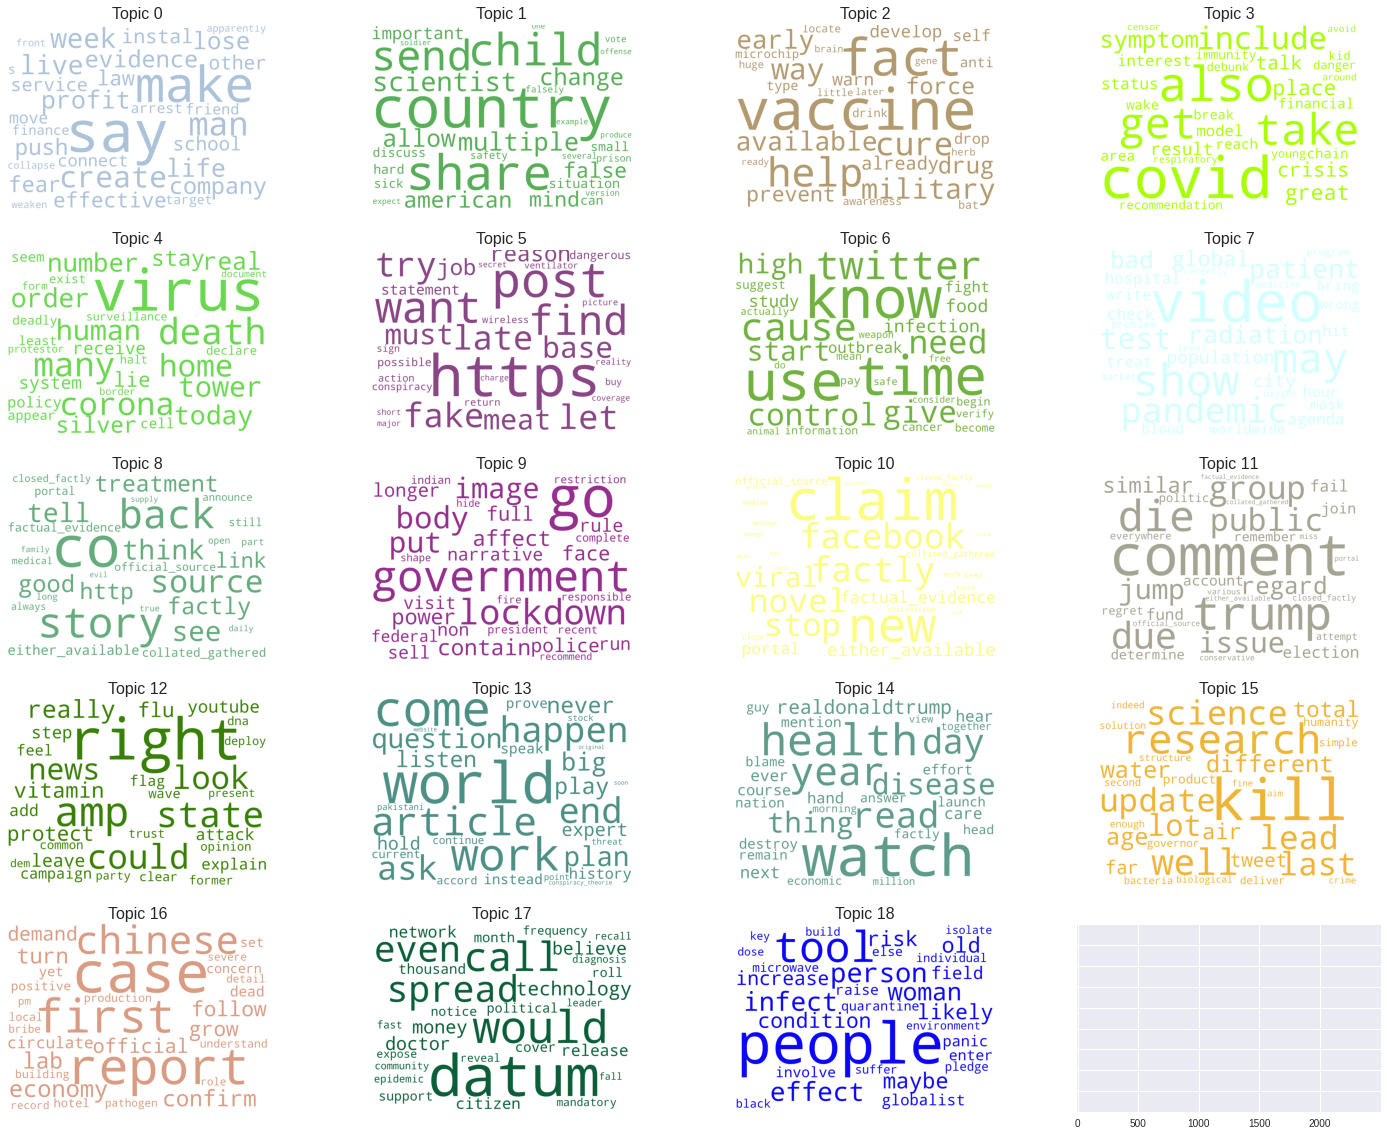

In [88]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'


cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=30,
                  colormap='paired',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False, num_topics=19, num_words=30)
topics.sort(key=lambda tup: tup[0])

fig, axes = plt.subplots(5, 4, figsize=(25,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=550)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.save('wc.png')
plt.show()

In [46]:
#topic_words = dict(topics[i][1])
from collections import Counter
topics = optimal_model.show_topics(formatted=False, num_topics=19, num_words=30)
topics.sort(key=lambda tup: tup[0])
data_flat = [w for w_list in topic_words for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

'''# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 4, figsize=(16,30), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylabel('Weight', color=cols[i])
    #ax.twin.label('Weight')
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 100)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')
    ax.set_facecolor('white')
    ax.grid(False)
    
fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Review Keywords', fontsize=22, y=1.05)    
plt.savefig('plot12.png')
plt.show()'''

'# Plot Word Count and Weights of Topic Keywords\nfig, axes = plt.subplots(5, 4, figsize=(16,30), sharey=True, dpi=160)\ncols = [color for name, color in mcolors.TABLEAU_COLORS.items()]\nfor i, ax in enumerate(axes.flatten()):\n    ax.bar(x=\'word\', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label=\'Word Count\')\n    ax_twin = ax.twinx()\n    ax_twin.bar(x=\'word\', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label=\'Weights\')\n    ax.set_ylabel(\'Word Count\', color=cols[i])\n    ax_twin.set_ylabel(\'Weight\', color=cols[i])\n    #ax.twin.label(\'Weight\')\n    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 100)\n    ax.set_title(\'Topic: \' + str(i), color=cols[i], fontsize=16)\n    ax.tick_params(axis=\'y\', left=False)\n    ax.set_xticklabels(df.loc[df.topic_id==i, \'word\'], rotation=30, horizontalalignment= \'right\')\n    ax.legend(loc=\'upper left\'); ax_twin.legend(loc=\'upper right\')\n    ax.set

In [84]:
topicsdf = pd.DataFrame(topics)

In [86]:
topicsdf

0                                                                                                    1
0  11  [(comment, 0.098340355), (trump, 0.062287066), (die, 0.051978003), (due, 0.037146825), (group, 0...
1  15  [(kill, 0.07558851), (research, 0.033022836), (well, 0.025189035), (science, 0.023282168), (lead...
2  16  [(case, 0.061257724), (report, 0.045945928), (first, 0.039122004), (chinese, 0.032729514), (econ...
3   2  [(vaccine, 0.107593074), (fact, 0.08464255), (help, 0.047844764), (cure, 0.029531708), (way, 0.0...
4   1  [(country, 0.06675232), (share, 0.046297453), (child, 0.03849812), (send, 0.035220347), (scienti...
5  10  [(claim, 0.11453011), (new, 0.07896068), (factly, 0.03343504), (facebook, 0.033295576), (novel, ...
6  17  [(datum, 0.08366242), (would, 0.047873955), (call, 0.037676927), (spread, 0.030932337), (even, 0...
7   7  [(video, 0.11316005), (show, 0.061680656), (may, 0.05562553), (pandemic, 0.039527565), (test, 0....
8   6  [(know, 0.06097213), (use, 0.0562306), (time, 0.055398766), (twitter, 0.043251194), (cause, 0.04...
9   8  [(co, 0.15200506), (story, 0.071277656), (back, 0.06433444), (source, 0.036431305), (see, 0.0277...

In [87]:
topicsdf.to_csv('topicsdf.csv')

In [47]:
topics

[(0,
  [('say', 0.1401485),
   ('make', 0.102030985),
   ('man', 0.035008423),
   ('create', 0.028036447),
   ('week', 0.023570279),
   ('live', 0.022019086),
   ('life', 0.019409642),
   ('profit', 0.019138671),
   ('lose', 0.017924827),
   ('evidence', 0.017305879),
   ('company', 0.017065976),
   ('push', 0.015506433),
   ('fear', 0.015159685),
   ('effective', 0.01366921),
   ('law', 0.013360199),
   ('instal', 0.012185669),
   ('other', 0.011715668),
   ('school', 0.011307382),
   ('service', 0.010408397),
   ('connect', 0.010044274),
   ('move', 0.009598711),
   ('friend', 0.008039991),
   ('arrest', 0.0074193818),
   ('finance', 0.006716972),
   ('target', 0.006569019),
   ('s', 0.006536608),
   ('apparently', 0.006299996),
   ('collapse', 0.0062909946),
   ('front', 0.006286168),
   ('weaken', 0.0062793517)]),
 (1,
  [('country', 0.06675232),
   ('share', 0.046297453),
   ('child', 0.03849812),
   ('send', 0.035220347),
   ('scientist', 0.027403185),
   ('multiple', 0.024298836

#**TSNE Clustering**

In [48]:
%%time
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(optimal_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# # Keep the well separated points (optional)
# arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=0, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

CPU times: user 4min 8s, sys: 975 ms, total: 4min 9s
Wall time: 2min 23s


In [51]:
import plotly.express as px
import plotly.graph_objects as go


tsne_lda_df = pd.DataFrame(tsne_lda)
tsne_lda_df.columns = ['col1', 'col2']
tsne_lda_df['topic'] = df_dominant_topic['Dominant_Topic']
raw_data = raw_data.reset_index(drop=True)
#tsne_lda_df['label'] = raw_data['label']
tsne_lda_df['Text'] = raw_data['Text']

tsne_lda_df['topic'] = tsne_lda_df['topic'].astype('object')

plt.set_cmap('tab20')
fig = px.scatter(tsne_lda_df, x='col1', y='col2', hover_name='Text',
              color='topic',
              #facet_col='topic', 
                color_discrete_sequence=px.colors.carto.Bold)
#                   color_discrete_map={"0": "blue", "1": "green", "2":"red", "3":"yellow", "4":"magenta", "5":"cyan",
#                                      "6":"deepskyblue", "7":"lightcoral", "8":"darkorange", "9":"aquamarine",
#                                      "10":"peru", "11":"darkkhaki"})

fig.update_layout(
    title=go.layout.Title(
        text="TSNE representation of fake posts segregated by topics",
        xref="paper",
        x=0
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="TSNE Dim 1",
            font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="TSNE Dim 2",
            font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"
            )
        )
    )
)

fig.show()

<Figure size 576x396 with 0 Axes>

#**Visualizing Topic Model**

In [52]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word, sort_topics=False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.085253 -0.044453       1        1  4.940410
1     -0.084204 -0.050677       2        1  4.244141
2      0.039005 -0.034980       3        1  4.151520
3     -0.091792 -0.032733       4        1  5.078802
4     -0.137468 -0.048553       5        1  5.301839
5     -0.021443 -0.031563       6        1  4.964560
6     -0.107159  0.409472       7        1  7.032591
7      0.034875  0.041711       8        1  6.819597
8      0.219834  0.018524       9        1  9.571249
9     -0.077722 -0.052795      10        1  4.986000
10     0.250835  0.019414      11        1  6.074404
11     0.104495 -0.026879      12        1  3.747153
12     0.064894 -0.016718      13        1  4.818777
13    -0.098637 -0.045609      14        1  4.943569
14     0.123290 -0.003967      15        1  4.964605
15    -0.107138 -0.055136      16        1  3.870440
16    -0.112347 -0.057627      17        1  3.998629
17     0.008904  0.016661      18        1  5.971539
18     0.077031 -0.004091      19        1  4.520176, topic_info=                     Term         Freq        Total Category  logprob  loglift
69                     co  1830.000000  1830.000000  Default  30.0000  30.0000
74                 people  1134.000000  1134.000000  Default  29.0000  29.0000
29                  virus  1165.000000  1165.000000  Default  28.0000  28.0000
34                    say   871.000000   871.000000  Default  27.0000  27.0000
87                  video   971.000000   971.000000  Default  26.0000  26.0000
227                 claim   875.000000   875.000000  Default  25.0000  25.0000
1196                right   795.000000   795.000000  Default  24.0000  24.0000
31                  covid   751.000000   751.000000  Default  23.0000  23.0000
170                    go   702.000000   702.000000  Default  22.0000  22.0000
103                 story   858.000000   858.000000  Default  21.0000  21.0000
12                   make   634.000000   634.000000  Default  20.0000  20.0000
1843                watch   630.000000   630.000000  Default  19.0000  19.0000
476                  back   775.000000   775.000000  Default  18.0000  18.0000
100               vaccine   562.000000   562.000000  Default  17.0000  17.0000
879                 datum   628.000000   628.000000  Default  16.0000  16.0000
400                 https   584.000000   584.000000  Default  15.0000  15.0000
693                  tool   550.000000   550.000000  Default  14.0000  14.0000
159                   new   603.000000   603.000000  Default  13.0000  13.0000
3580              comment   463.000000   463.000000  Default  12.0000  12.0000
2624                 also   505.000000   505.000000  Default  11.0000  11.0000
302                  know   539.000000   539.000000  Default  10.0000  10.0000
86                   show   529.000000   529.000000  Default   9.0000   9.0000
1540                 fact   442.000000   442.000000  Default   8.0000   8.0000
582            government   460.000000   460.000000  Default   7.0000   7.0000
263                   use   497.000000   497.000000  Default   6.0000   6.0000
243                  time   490.000000   490.000000  Default   5.0000   5.0000
130                   may   477.000000   477.000000  Default   4.0000   4.0000
231                 world   418.000000   418.000000  Default   3.0000   3.0000
376                  take   409.000000   409.000000  Default   2.0000   2.0000
32                    get   407.000000   407.000000  Default   1.0000   1.0000
34                    say   871.145719   871.463690   Topic1  -1.9651   3.0074
12                   make   634.211942   634.529913   Topic1  -2.2825   3.0072
82                    man   217.608013   217.925984   Topic1  -3.3522   3.0063
186                create   174.271077   174.589048   Topic1  -3.5742   3.0059
1510                 week   146.509927   146.827898   Topic1  -3.7478   3.0056


In [53]:
p = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word, sort_topics=False)
pyLDAvis.save_html(p, 'finallda.html')

#**Try**

IndexError: ignored

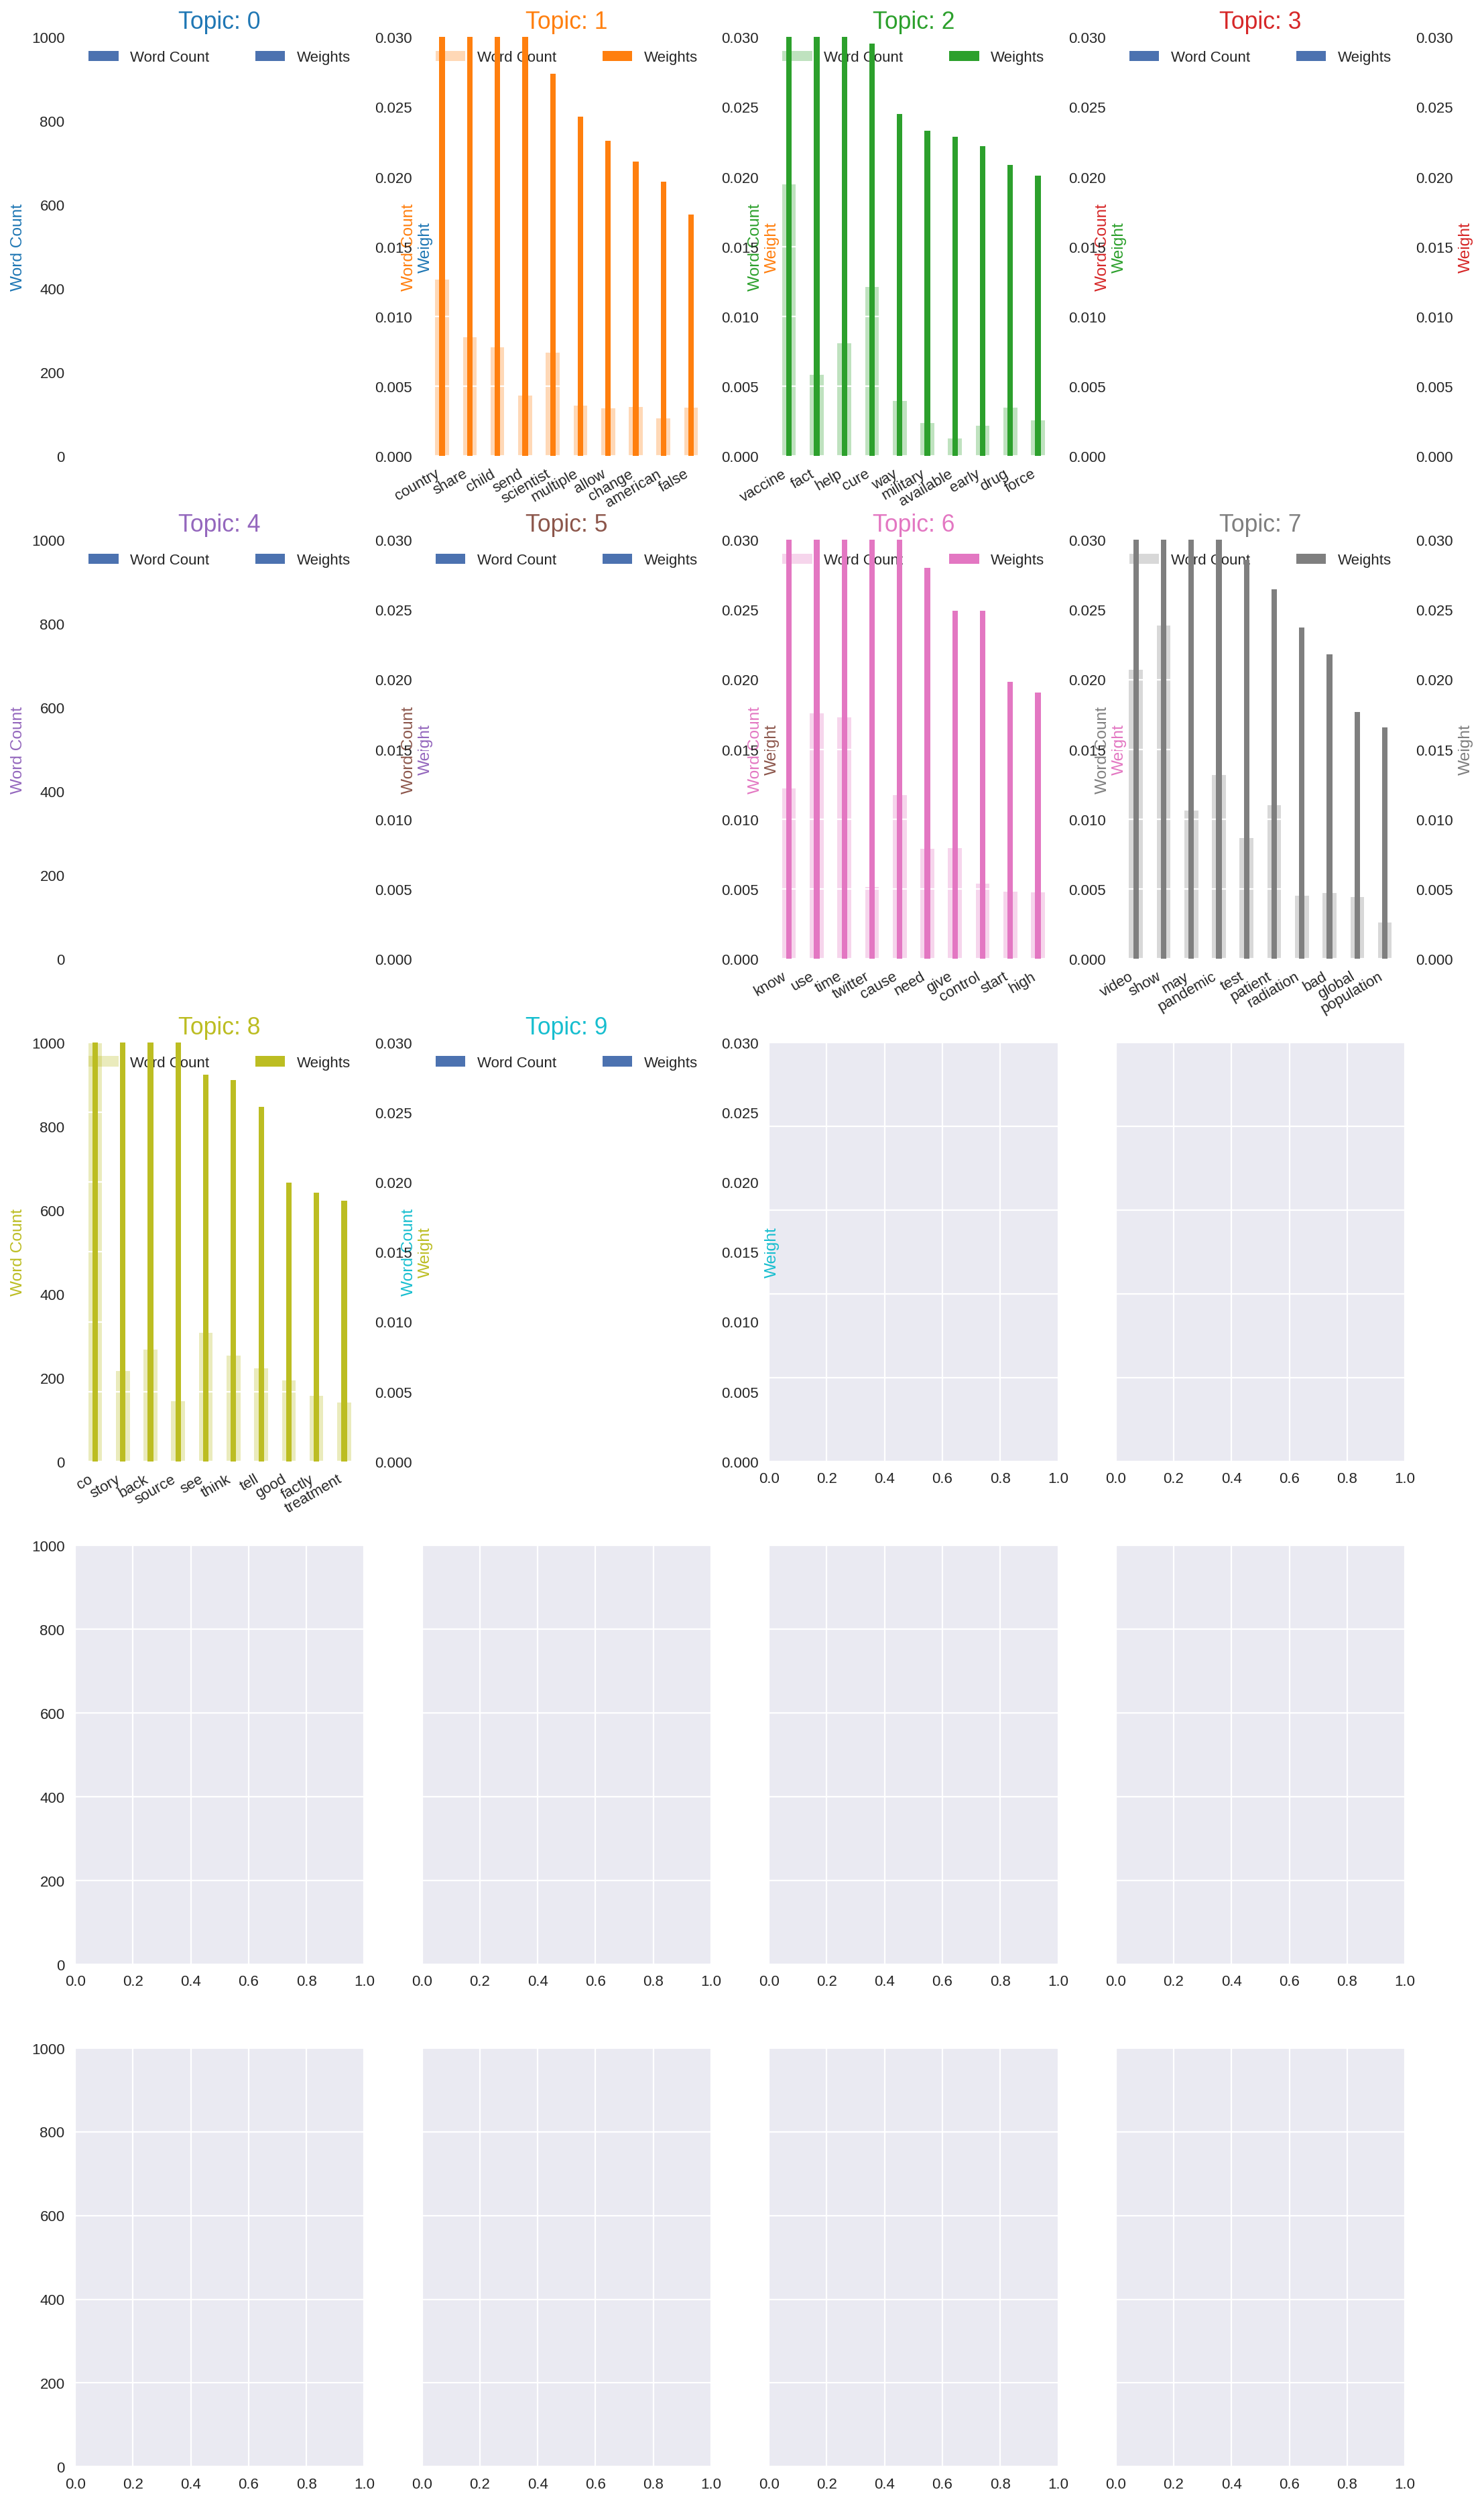

In [82]:
from collections import Counter
topics = optimal_model.show_topics(formatted=False)
data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 4, figsize=(16,30), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylabel('Weight', color=cols[i])
    #ax.twin.label('Weight')
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 1000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')
    ax.set_facecolor('white')
    ax.grid(False)
    
fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Review Keywords', fontsize=22, y=1.05)    
plt.savefig('plot12.png')
plt.show()

In [63]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=optimal_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in optimal_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

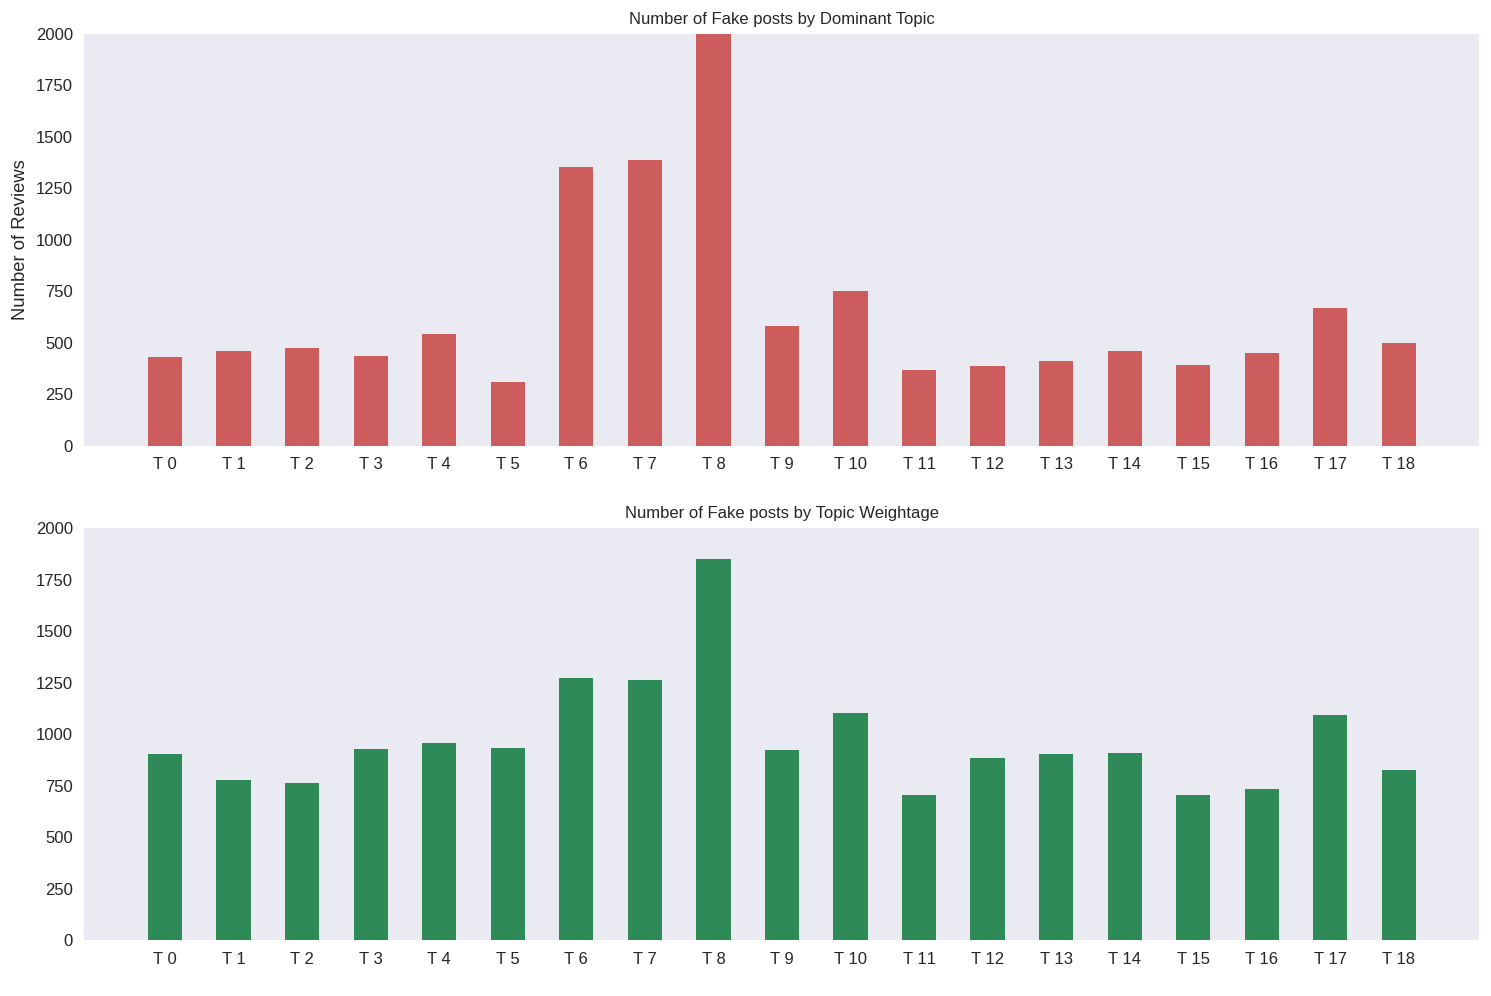

In [71]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='indianred')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'T ' + str(x)+ '\n')
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Fake posts by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Reviews')
ax1.set_ylim(0, 2000)
ax1.grid(False)
# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='seagreen')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Fake posts by Topic Weightage', fontdict=dict(size=10))
#ax2.set_ylim(0, 1000)
ax2.grid(False)
plt.savefig('pic4.png')
plt.show()

In [73]:
#dividing datasets according to topic subsets
topic0 = df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 0.0]
topic1 = df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 1.0]
topic2 = df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 2.0]
topic3 = df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 3.0]
topic4 = df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 4.0]
topic5 = df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 5.0]
topic6 = df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 6.0]
topic7 = df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 7.0]
topic8 = df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 8.0]
topic9 = df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 9.0]
topic10 = df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 10.0]
topic11 = df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 11.0]
topic12 = df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 12.0]
topic13 = df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 13.0]
topic14 = df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 14.0]
topic15 = df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 15.0]
topic16 = df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 16.0]
topic17 = df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 17.0]
topic18 = df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 18.0]
topic19 = df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 19.0]